In [1]:
# import findspark
# findspark.init('/home/ubuntu/spark-3.0.1-bin-hadoop2.7')
import pyspark
from pyspark.sql import SparkSession
from IPython.core.display import HTML

display(HTML("<style>pre { white-space: pre !important; }</style>"))

spark = SparkSession.builder.appName('722-BDAS-bgao150').getOrCreate()

# Step2 Data Understanding

In [2]:
df = spark.read.csv('data/price-concatenation-step2.csv', header=True, inferSchema=True)
print("rows: " + str(df.count()), "columns: " + str(len(df.columns)))
df.show(10)

rows: 1129 columns: 45
+-----------+-----------+-----------+-----------+------------+----------------+-------------+---------+--------------+---------+-----------------+-------------------+--------------------+----------------+-----------------+---------------------+-----------------+----------------+----------------------+---------------+--------------+--------------------+-------------------+---------------+------------------+-----------------------+----------------------+--------+------------------+----------+--------+--------+-------+---------+--------------+---------------+--------+------------------+----------+--------+--------+-------+---------+--------------+---------------+
|nasdaq_Date|nasdaq_Open|nasdaq_High| nasdaq_Low|nasdaq_Close|nasdaq_Adj_Close|nasdaq_Volume|gold_Name|gold_US dollar|gold_Euro|gold_Japanese yen|gold_Pound sterling|gold_Canadian dollar|gold_Swiss franc|gold_Indian rupee|gold_Chinese renmimbi|gold_Turkish lira|gold_Saudi riyal|gold_Indonesian rupiah|gold_U

In [3]:
df.printSchema()

root
 |-- nasdaq_Date: string (nullable = true)
 |-- nasdaq_Open: double (nullable = true)
 |-- nasdaq_High: double (nullable = true)
 |-- nasdaq_Low: double (nullable = true)
 |-- nasdaq_Close: double (nullable = true)
 |-- nasdaq_Adj_Close: double (nullable = true)
 |-- nasdaq_Volume: long (nullable = true)
 |-- gold_Name: string (nullable = true)
 |-- gold_US dollar: string (nullable = true)
 |-- gold_Euro: string (nullable = true)
 |-- gold_Japanese yen: string (nullable = true)
 |-- gold_Pound sterling: string (nullable = true)
 |-- gold_Canadian dollar: string (nullable = true)
 |-- gold_Swiss franc: string (nullable = true)
 |-- gold_Indian rupee: string (nullable = true)
 |-- gold_Chinese renmimbi: string (nullable = true)
 |-- gold_Turkish lira: string (nullable = true)
 |-- gold_Saudi riyal: string (nullable = true)
 |-- gold_Indonesian rupiah: string (nullable = true)
 |-- gold_UAE dirham: string (nullable = true)
 |-- gold_Thai baht: string (nullable = true)
 |-- gold_Vietn

## price correlation

In [4]:
from pyspark.ml.stat import Correlation
from pyspark.ml.linalg import Vectors
from pyspark.ml.feature import VectorAssembler
from pyspark.sql.functions import *


for col_name in [i for i in df.columns if i not in ('nasdaq_Date', "btc_Date", "eth_Date", "gold_Name", "btc_Symbol", "eth_Symbol")]:
    df = df.withColumn(col_name, regexp_replace(col_name, ',', '').cast('float'))

df_temp_removed_na = df.na.fill(0)

# convert to vector column first
vector_col = "corr_features"
assembler = VectorAssembler(inputCols=["btc_Close", "eth_Close", "gold_US dollar", "nasdaq_Close"], outputCol=vector_col)
df_vector = assembler.transform(df_temp_removed_na).select(vector_col)

# get correlation matrix
matrix = Correlation.corr(df_vector, vector_col)
print(matrix.collect()[0]["pearson({})".format(vector_col)].values.reshape(4, 4))

[[ 1.          0.5516963   0.07153555  0.07791445]
 [ 0.5516963   1.         -0.04120842 -0.04275535]
 [ 0.07153555 -0.04120842  1.          0.92750443]
 [ 0.07791445 -0.04275535  0.92750443  1.        ]]


## normalization and plot

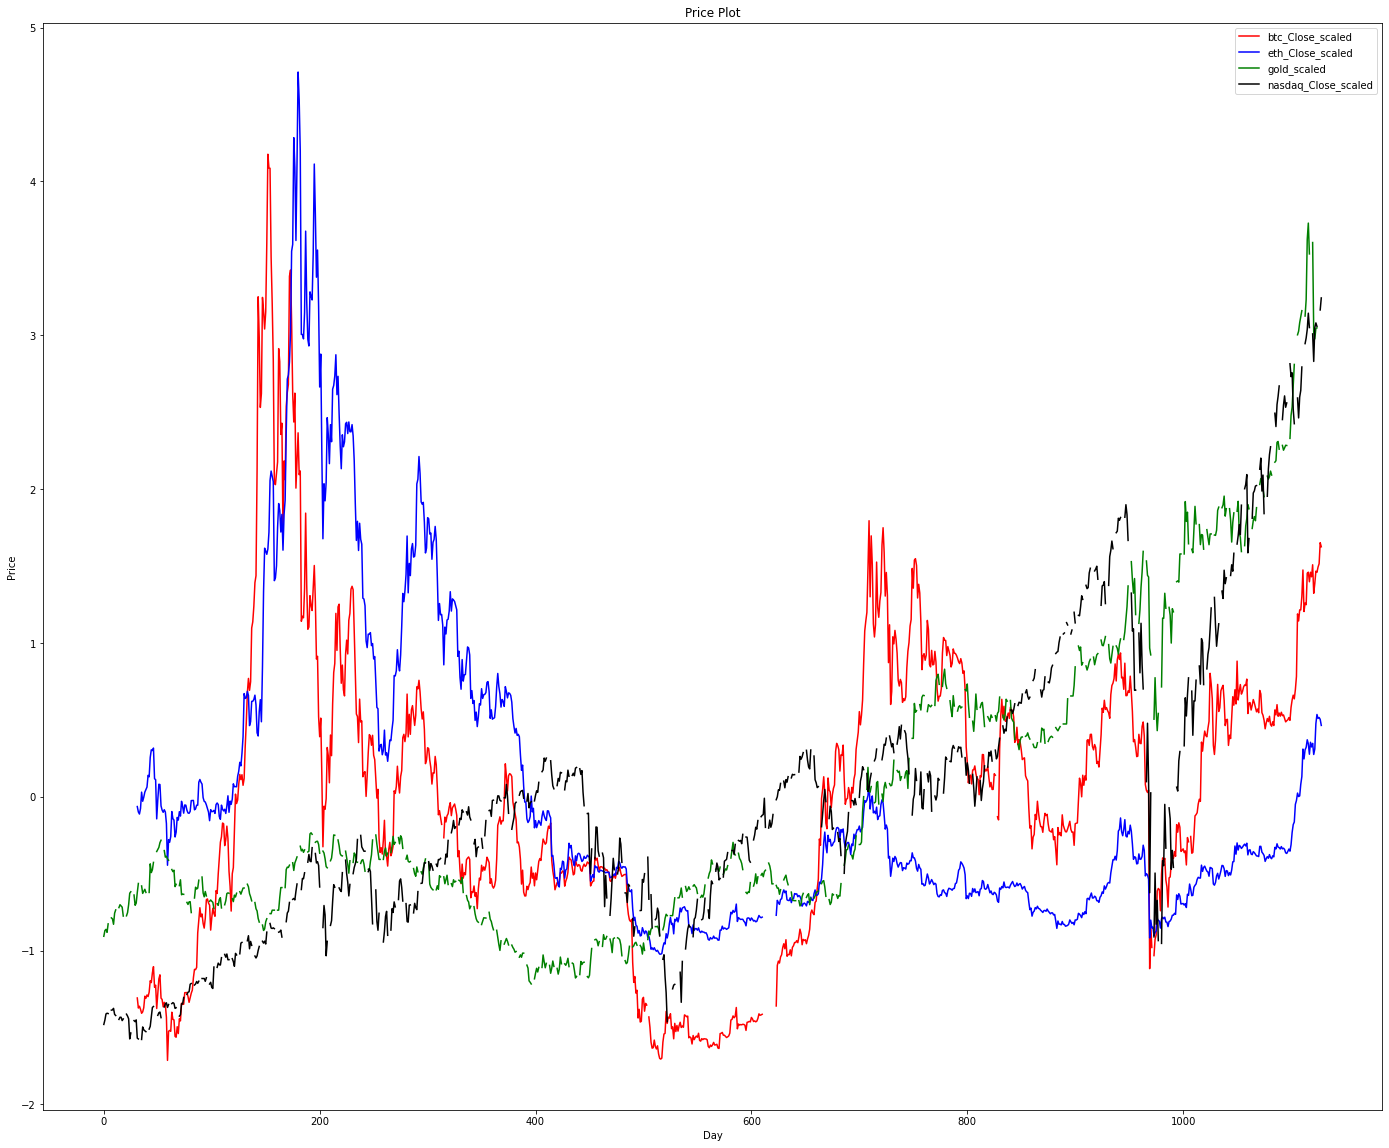

In [5]:
#I can't use the normolization function provided by pyspark directly as it expect vectors and verctorized rows, but not columns
mean_btc_Close, sttdev_btc_Close = df.select(mean("btc_Close"), stddev("btc_Close")).first()
df_normalization = df.withColumn("btc_Close_scaled", (col("btc_Close") - mean_btc_Close) / sttdev_btc_Close)

mean_eth_Close, sttdev_eth_Close = df_normalization.select(mean("eth_Close"), stddev("eth_Close")).first()
df_normalization = df_normalization.withColumn("eth_Close_scaled", (col("eth_Close") - mean_eth_Close) / sttdev_eth_Close)

mean_gold, sttdev_gold = df_normalization.select(mean("gold_US dollar"), stddev("gold_US dollar")).first()
df_normalization = df_normalization.withColumn("gold_scaled", (col("gold_US dollar") - mean_gold) / sttdev_gold)

mean_nasdaq_Close, sttdev_nasdaq_Close = df_normalization.select(mean("nasdaq_Close"), stddev("nasdaq_Close")).first()
df_normalization = df_normalization.withColumn("nasdaq_Close_scaled", (col("nasdaq_Close") - mean_nasdaq_Close) / sttdev_nasdaq_Close)


import matplotlib.pyplot as plt

btc_Close_scaled = [val.btc_Close_scaled for val in df_normalization.select('btc_Close_scaled').collect()]
eth_Close_scaled = [val.eth_Close_scaled for val in df_normalization.select('eth_Close_scaled').collect()]
gold_scaled = [val.gold_scaled for val in df_normalization.select('gold_scaled').collect()]
nasdaq_Close_scaled = [val.nasdaq_Close_scaled for val in df_normalization.select('nasdaq_Close_scaled').collect()]

plt.figure(figsize=(24, 20))

plt.plot(btc_Close_scaled, color='red',label='btc_Close_scaled')
plt.plot(eth_Close_scaled, color='blue',label='eth_Close_scaled')
plt.plot(gold_scaled, color='green',label='gold_scaled')
plt.plot(nasdaq_Close_scaled, color='black',label='nasdaq_Close_scaled')
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys())
plt.title('Price Plot')
plt.xlabel('Day')
plt.ylabel('Price')
plt.rcParams['figure.figsize'] = [24, 16]
plt.show()


## price and trading volumn correlation

In [7]:

# convert to vector column first
vector_col = "corr_features"
assembler = VectorAssembler(inputCols=[ "btc_Volume_USDT", "eth_Volume_USDT", "nasdaq_Volume"], outputCol=vector_col)
df_vector = assembler.transform(df_temp_removed_na).select(vector_col)

# get correlation matrix
matrix = Correlation.corr(df_vector, vector_col)
print(matrix.collect()[0]["pearson({})".format(vector_col)].values.reshape(3, 3))

[[1.         0.75408106 0.34738782]
 [0.75408106 1.         0.30624798]
 [0.34738782 0.30624798 1.        ]]


In [8]:
df.select("btc_Close", "eth_Close", "gold_US dollar", "nasdaq_Close").describe().show()

+-------+------------------+------------------+------------------+------------------+
|summary|         btc_Close|         eth_Close|    gold_US dollar|      nasdaq_Close|
+-------+------------------+------------------+------------------+------------------+
|  count|              1080|              1086|               805|               779|
|   mean| 7818.477486617477|316.45284533983653|1397.0658385093168| 7848.788765394335|
| stddev|2701.3662422346897|227.42930485820233| 179.6836275035895|1036.6973534477277|
|    min|           3189.02|             83.76|            1178.4|           6192.92|
|    max|          19102.66|           1388.02|            2067.2|          11210.84|
+-------+------------------+------------------+------------------+------------------+



## Null values and Outlier

In [9]:
df.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in df.columns]).toPandas().transpose()

,0
nasdaq_Date,0
nasdaq_Open,350
nasdaq_High,350
nasdaq_Low,350
nasdaq_Close,350
nasdaq_Adj_Close,350
nasdaq_Volume,350
gold_Name,4
gold_US dollar,324
gold_Euro,324


## Outlier

In [11]:
import pyspark.sql.functions as f

bounds = {
    c: dict(zip(["q1", "q3"], df.approxQuantile(c, [0.25, 0.75], 0)))
    for c in [i for i in df.columns if i not in ('nasdaq_Date', "btc_Date", "eth_Date", "gold_Name", "btc_Symbol", "eth_Symbol")]
}
for c in bounds:
    iqr = bounds[c]['q3'] - bounds[c]['q1']
    bounds[c]['lower'] = bounds[c]['q1'] - (iqr * 1.5)
    bounds[c]['upper'] = bounds[c]['q3'] + (iqr * 1.5)

outlier_df = df.select(
    "*",
    *[
        f.when(
            isnull(f.col(c)) | f.col(c).between(bounds[c]['lower'], bounds[c]['upper']),
            0
        ).otherwise(1).alias(c+"_out") 
        for c in [i for i in df.columns if i not in ('nasdaq_Date', "btc_Date", "eth_Date", "gold_Name", "btc_Symbol", "eth_Symbol")]
    ]
)
# outlier_df.show(100)

outlier_df.select(sum("nasdaq_Open_out"), sum( "nasdaq_High_out"), sum( "nasdaq_Low_out"), sum( "nasdaq_Close_out"), sum( "nasdaq_Adj_Close_out"), sum( "nasdaq_Volume_out"), sum( "gold_US dollar_out"), sum( "gold_Euro_out"), sum( "gold_Japanese yen_out"), sum( "gold_Pound sterling_out"), sum( "gold_Canadian dollar_out"), sum( "gold_Swiss franc_out"), sum( "gold_Indian rupee_out"), sum( "gold_Chinese renmimbi_out"), sum( "gold_Turkish lira_out"), sum( "gold_Saudi riyal_out"), sum( "gold_Indonesian rupiah_out"), sum( "gold_UAE dirham_out"), sum( "gold_Thai baht_out"), sum( "gold_Vietnamese dong_out"), sum( "gold_Egyptian pound_out"), sum( "gold_Korean won_out"), sum( "gold_Russian ruble_out"), sum( "gold_South African rand_out"), sum( "gold_Australian dollar_out"), sum( "btc_Unix_Timestamp_out"), sum( "btc_Open_out"), sum( "btc_High_out"), sum( "btc_Low_out"), sum( "btc_Close_out"), sum( "btc_Volume_btc_out"), sum( "btc_Volume_USDT_out"), sum( "eth_Unix_Timestamp_out"), sum( "eth_Open_out"), sum( "eth_High_out"), sum( "eth_Low_out"), sum( "eth_Close_out"), sum( "eth_Volume_btc_out"), sum( "eth_Volume_USDT_out")).toPandas().transpose()


,0
sum(nasdaq_Open_out),49
sum(nasdaq_High_out),52
sum(nasdaq_Low_out),44
sum(nasdaq_Close_out),49
sum(nasdaq_Adj_Close_out),49
sum(nasdaq_Volume_out),129
sum(gold_US dollar_out),19
sum(gold_Euro_out),0
sum(gold_Japanese yen_out),23
sum(gold_Pound sterling_out),4
